In [1]:
from google.colab import drive
drive.mount('/content/drive')

PATH_BASE = '/content/drive/MyDrive/ws_colab/going_deeper/project/gd_10'
PATH_DATA = PATH_BASE+'/data/training'


Mounted at /content/drive


In [2]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras import Input, Model
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize


# 개선된 U-Net 모델 만들기

# Step 1. KITTI 데이터셋 수집과 구축
- U-Net++는 메모리 사용량이 U-Net보다 많음 
- 배치 사이즈를 적절히 줄여서 설정

In [3]:
def build_augmentation(is_train=True):
    # 훈련용 데이터일 경우
    # 50%의 확률로 각 augmentation 
    if is_train:
        flip_hori = HorizontalFlip(p=0.5)
        crop_ =  RandomSizedCrop(min_max_height=(300, 370), w2h_ratio=370/1242, 
                                 height=224, width=224, p=0.5)
        resize_ = Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
        return Compose([HorizontalFlip(p=0.5), crop_, Resize(width=224, height=224)])
    # 테스트용 데이터일 경우에는 resize만 수행 
    return Compose([Resize(width=224, height=224)])


In [4]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)


# Step 2. U-Net++ 모델의 구현
- 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능


In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                dir_path,
                batch_size=16,
                img_size=(224, 224, 3),
                output_size=(224, 224),
                is_train=True,
                augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
        
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                            index*self.batch_size:
                            (index + 1)*self.batch_size
                            ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [6]:
train_generator_16 = KittiGenerator(
    PATH_DATA, 
    augmentation=augmentation_train
)

train_generator_8 = KittiGenerator(
    PATH_DATA, 
    augmentation=augmentation_train,
    batch_size=8
)

test_generator_16 = KittiGenerator(
    PATH_DATA, 
    augmentation=augmentation_test,
    is_train=False
)

test_generator_8 = KittiGenerator(
    PATH_DATA, 
    augmentation=augmentation_test,
    is_train=False,
    batch_size=8
)



In [7]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    layer_ = []
    buf_in = inputs
    for size_ in [64, 128, 256, 512, 1024]:
        conv = Conv2D(size_, 3, activation='relu', padding='same',kernel_initializer='he_normal')(buf_in)
        conv = Conv2D(size_, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
        if size_ >= 512:
            conv = Dropout(0.5)(conv)
        if size_ == 1024:
            buf_in = conv
            layer_.append(conv)
            break
        layer_.append(conv)
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
        buf_in = pool
    layer_.reverse()

    # conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    # conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    # conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    # pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    # conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    # pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    # conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    # drop4 = Dropout(0.5)(conv4)
    # pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    # conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    # drop5 = Dropout(0.5)(conv5)
    
    #Expanding Path
    buf_in = layer_[0]
    for idx, size_ in enumerate([512, 256, 128, 64]):
        up_ = Conv2DTranspose(size_, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(buf_in)
        merge_ = concatenate([layer_[idx+1], up_], axis = 3)
        conv = Conv2D(size_, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
        conv = Conv2D(size_, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
        buf_in = conv

    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(buf_in)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs = inputs, outputs = conv10)
    return model

    # up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    # merge6 = concatenate([drop4,up6], axis = 3)
    # conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    # conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

    # up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    # merge7 = concatenate([conv3,up7], axis = 3)
    # conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    # conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

    # up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    # merge8 = concatenate([conv2,up8], axis = 3)
    # conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    # conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)

    # up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    # merge9 = concatenate([conv1,up9], axis = 3)
    # conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    # conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  

    # conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    # conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # model = Model(inputs = inputs, outputs = conv10)
    # return model


In [8]:
def build_model_adv(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    filter = [64, 128, 256, 512, 1024]
    layer_backbone = []
    buf_in = inputs
    for size_ in filter:
        conv = Conv2D(size_, 3, activation='relu', padding='same',kernel_initializer='he_normal')(buf_in)
        conv = Conv2D(size_, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
        # if size_ >= 512:
        #     conv = Dropout(0.5)(conv)
        if size_ == 1024:
            layer_backbone.append(conv)
            buf_in = conv
            break
        layer_backbone.append(conv)
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
        buf_in = pool
    layer_backbone.reverse()

    
    filter = filter[:-1]
    filter.reverse()
    layer_up = []
    # Skip Connection
    num_loop = len(layer_backbone[1:])
    for idx in range(1, num_loop):
        num_filter = filter[idx]
        up_ = Conv2DTranspose(num_filter, (2, 2), strides=(2, 2), name=f'x_{num_loop-idx}_{idx}', padding='same')(layer_backbone[idx])
        merge_ = concatenate([up_, layer_backbone[idx+1]], name=f'merge_{num_loop-idx}_{idx}', axis=3)
        conv = Conv2D(num_filter, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
        conv = Conv2D(num_filter, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
        layer_up.append(conv)

        for cnt in range(idx-1):
            up_ = Conv2DTranspose(num_filter, (2, 2), strides=(2, 2), name=f'x_{num_loop-idx}_{idx+cnt+1}', padding='same')(layer_up[idx+cnt-2])
            list_merge = []
            list_merge.append(up_)
            list_merge.append(layer_backbone[idx+1])
            for i in range(cnt+1):
                list_merge.append(layer_up[2*idx-3+i])
            merge_ = concatenate(list_merge, name=f'merge_{num_loop-idx}_{idx+cnt+1}', axis=3)
            conv = Conv2D(num_filter, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
            conv = Conv2D(num_filter, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
            layer_up.append(conv)


    # # layer_up[0] 
    # up_ = Conv2DTranspose(256, (2, 2), strides=(2, 2), name='up32', padding='same')(layer_backbone[1])
    # merge_ = concatenate([up_, layer_backbone[2]], name='merge32', axis=3)
    # conv = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
    # conv = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    # layer_up.append(conv)

    # # layer_up[1]
    # up_ = Conv2DTranspose(128, (2, 2), strides=(2, 2), name='up32', padding='same')(layer_backbone[2])
    # merge_ = concatenate([up_, layer_backbone[3]], name='merge32', axis=3)
    # conv = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
    # conv = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    # layer_up.append(conv)

    # # layer_up[2]
    # up_ = Conv2DTranspose(128, (2, 2), strides=(2, 2), name='up32', padding='same')(layer_up[0])
    # merge_ = concatenate([up_, layer_backbone[3], layer_up[1]], name='merge32', axis=3)
    # conv = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
    # conv = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    # layer_up.append(conv)

    # # layer_up[3]
    # up_ = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up32', padding='same')(layer_backbone[3])
    # merge_ = concatenate([up_, layer_backbone[4]], name='merge32', axis=3)
    # conv = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
    # conv = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    # layer_up.append(conv)

    # # layer_up[4]
    # up_ = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up32', padding='same')(layer_up[1])
    # merge_ = concatenate([up_, layer_backbone[4], layer_up[3]], name='merge32', axis=3)
    # conv = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
    # conv = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    # layer_up.append(conv)

    # # layer_up[5]
    # up_ = Conv2DTranspose(64, (2, 2), strides=(2, 2), name='up32', padding='same')(layer_up[2])
    # merge_ = concatenate([up_, layer_backbone[4], layer_up[3], layer_up[4]], name='merge32', axis=3)
    # conv = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
    # conv = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    # layer_up.append(conv)


    # Upsampling
    # Expanding Path
    idx_up = 0
    buf_in = layer_backbone[0]
    for idx, size_ in enumerate(filter):
        up_ = Conv2DTranspose(size_, 2, name=f'up_{idx}', activation='relu', strides=(2,2), kernel_initializer='he_normal')(buf_in)
        list_merge = []
        list_merge.append(up_)
        list_merge.append(layer_backbone[idx+1])
        for _ in range(idx):
            list_merge.append(layer_up[idx_up])
            idx_up+=1
        print(idx, 'aaa', list_merge)
        merge_ = concatenate(list_merge, name=f'merge_{idx}', axis = 3)
        conv = Conv2D(size_, 3, name=f'conv_{idx}_1', activation='relu', padding='same',kernel_initializer='he_normal')(merge_)
        conv = Conv2D(size_, 3, name=f'conv_{idx}_2', activation='relu', padding='same',kernel_initializer='he_normal')(conv)
        buf_in = conv

    # output_1 = Conv2D(1, 1, activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    
    output_1 = Conv2D(1, 1, activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same')(layer_up[3])
    output_2 = Conv2D(1, 1, activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same')(layer_up[4])
    output_3 = Conv2D(1, 1, activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same')(layer_up[5])
    output_4 = Conv2D(1, 1, activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same')(buf_in)
    model = Model(inputs = inputs, outputs = [output_4])
    # model = Model(inputs = inputs, outputs = [output_1, output_2, output_3, output_4])
    return model


In [9]:
PATH_MODEL_UNET = PATH_BASE+'/seg_model_unet.h5'
PATH_MODEL_UNET_ADV = PATH_BASE+'/seg_model_unet_adv.h5'


In [10]:
model_unet = build_model()
model_unet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [11]:
model_unet_adv = build_model_adv()
model_unet_adv.summary()


0 aaa [<KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'up_0')>, <KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'conv2d_27')>]
1 aaa [<KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'up_1')>, <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'conv2d_25')>, <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'conv2d_31')>]
2 aaa [<KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'up_2')>, <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'conv2d_23')>, <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'conv2d_33')>, <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'conv2d_35')>]
3 aaa [<KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'up_3')>, <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'conv2d_21')>, <KerasTensor: shape=(None

In [ ]:
model_unet.compile(optimizer = optimizers.Adam(1e-4), loss = 'binary_crossentropy')
history = model_unet.fit(
     train_generator_8,
     validation_data=test_generator_8,
     steps_per_epoch=len(train_generator_8),
     epochs=100,
)

model_unet.save(PATH_MODEL_UNET)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 38s 862ms/step - loss: 0.6907 - val_loss: 0.6750
Epoch 2/100
22/22 [==============================] - 8s 356ms/step - loss: 0.3673 - val_loss: 0.1178
Epoch 3/100
22/22 [==============================] - 8s 358ms/step - loss: 0.0675 - val_loss: 0.0675
Epoch 4/100
22/22 [==============================] - 8s 354ms/step - loss: 0.0560 - val_loss: 0.0652
Epoch 5/100
22/22 [==============================] - 8s 357ms/step - loss: 0.0508 - val_loss: 0.0523
Epoch 6/100
22/22 [==============================] - 8s 359ms/step - loss: 0.0552 - val_loss: 0.0626
Epoch 7/100
22/22 [==============================] - 8s 359ms/step - loss: 0.0613 - val_loss: 0.0495
Epoch 8/100
22/22 [==============================] - 8s 357ms/step - loss: 0.0457 - val_loss: 0.0406
Epoch 9/100
22/22 [==============================] - 8s 361ms/step - loss: 0.0426 - val_loss: 0.0406
Epoch 10/100
22/22 [==============================] - 8s 359ms/step - loss: 0.0450 - val_l

In [ ]:
model_unet_adv.compile(optimizer = optimizers.Adam(1e-4), loss = 'binary_crossentropy')
history_adv  = model_unet_adv.fit(
     train_generator_8,
     validation_data=test_generator_8,
     steps_per_epoch=len(train_generator_8),
     epochs=100,
)

model_unet_adv.save(PATH_MODEL_UNET_ADV)  #학습한 모델을 저장해 주세요.


Epoch 1/100
22/22 [==============================] - 28s 486ms/step - loss: 0.6567 - val_loss: 0.5505
Epoch 2/100
22/22 [==============================] - 10s 443ms/step - loss: 0.1705 - val_loss: 0.0528
Epoch 3/100
22/22 [==============================] - 10s 442ms/step - loss: 0.0720 - val_loss: 0.0694
Epoch 4/100
22/22 [==============================] - 10s 441ms/step - loss: 0.0702 - val_loss: 0.0591
Epoch 5/100
22/22 [==============================] - 10s 442ms/step - loss: 0.0659 - val_loss: 0.0548
Epoch 6/100
22/22 [==============================] - 10s 442ms/step - loss: 0.0580 - val_loss: 0.0529
Epoch 7/100
22/22 [==============================] - 10s 442ms/step - loss: 0.0464 - val_loss: 0.0448
Epoch 8/100
22/22 [==============================] - 10s 442ms/step - loss: 0.0455 - val_loss: 0.0547
Epoch 9/100
22/22 [==============================] - 10s 441ms/step - loss: 0.0357 - val_loss: 0.0366
Epoch 10/100
22/22 [==============================] - 10s 442ms/step - loss: 0.045

In [ ]:
# model_path = PATH_BASE+'/data/training/seg_model_unet.h5'
# model = tf.keras.models.load_model(model_path)

In [12]:
model_unet = tf.keras.models.load_model(PATH_MODEL_UNET)
model_unet_adv = tf.keras.models.load_model(PATH_MODEL_UNET_ADV)


# Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
- 두 모델의 정량적, 정성적 성능을 비교
- 시각화, IoU 계산 등을 체계적으로 시도

In [13]:
def get_output(model, preproc, image_path, output_path=None):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.

    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    background.show()
    output.show()
    return output 

def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score


In [14]:
def get_output_predict(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역
        return output, prediction, target
    else:
        return output, prediction, _

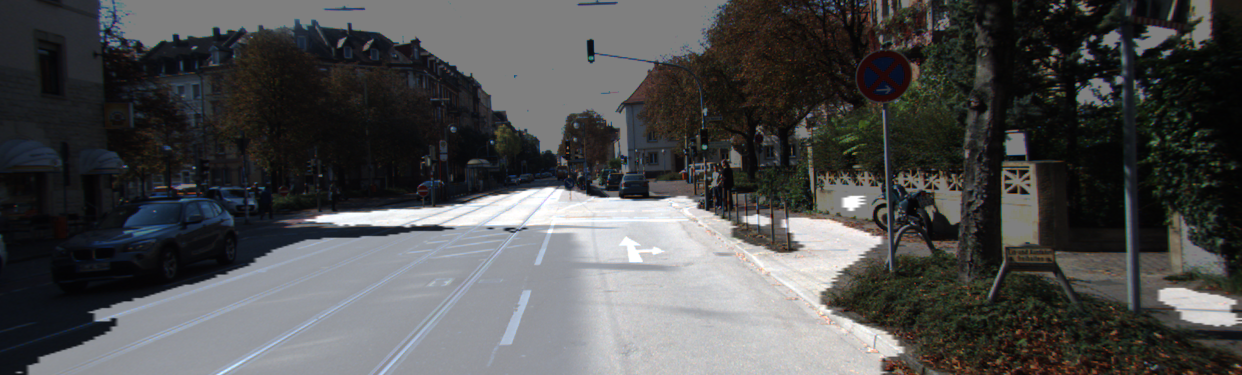

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
    model_unet, 
    augmentation_test,
    image_path=PATH_BASE + '/data/training' + f'/image_2/00{str(i).zfill(4)}_10.png',
)

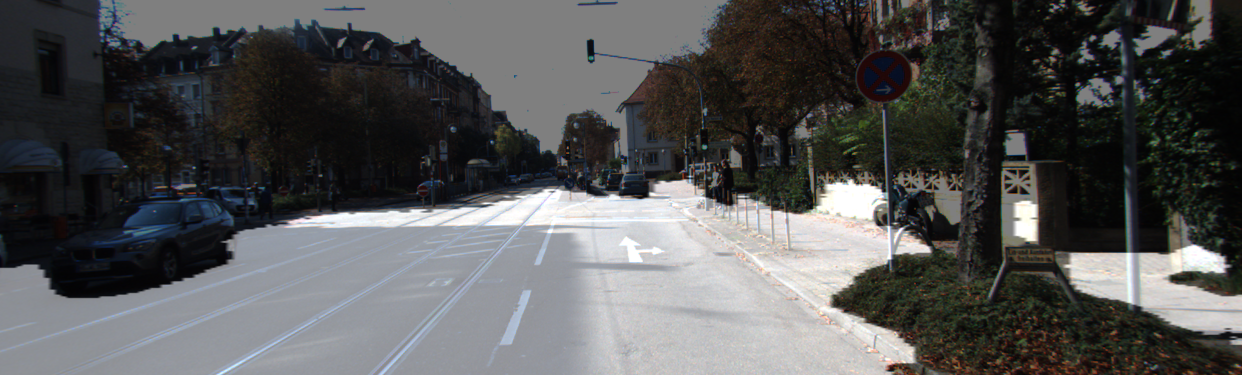

In [ ]:
get_output(
    model_unet_adv, 
    augmentation_test,
    image_path=PATH_BASE + '/data/training' + f'/image_2/00{str(i).zfill(4)}_10.png',
)

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_1, prediction_1, target_1 = get_output_predict(
    model_unet, 
    augmentation_test,
    image_path=PATH_BASE + '/data/training' + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=PATH_BASE +'/data/training' + f'/result_{str(i).zfill(3)}_1.png',
    label_path=PATH_BASE +'/data/training' + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target_1, prediction_1)

IoU : 0.790734


0.7907342532351469

In [ ]:
output_2, prediction_2, target_2 = get_output_predict(
    model_unet_adv, 
    augmentation_test,
    image_path=PATH_BASE + '/data/training' + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=PATH_BASE + '/data/training' + f'/result_{str(i).zfill(3)}_2.png',
    label_path=PATH_BASE + '/data/training' + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target_2, prediction_2)

IoU : 0.775221


0.7752206809583859

# Unet, Unet++ 비교
- IoU : 
    - Unet : 79.07% 
    - Unet++ : 77.52%

- 두개 모두 나쁘지 않은 성능
- 하지만 개선된 Unet++이 더 낮은 성능

- Unet++
    - 시각화 이미지를 보면 Unet++이 어두운 부분에 대해서 더 관대하게 판별
    - 상대적으로 더 넓은 부분을 허용, 도로가 아닌 부분도 포함 됨
    - 하지만 어두운 부분, 그늘에 대해서 판별이 가능해짐







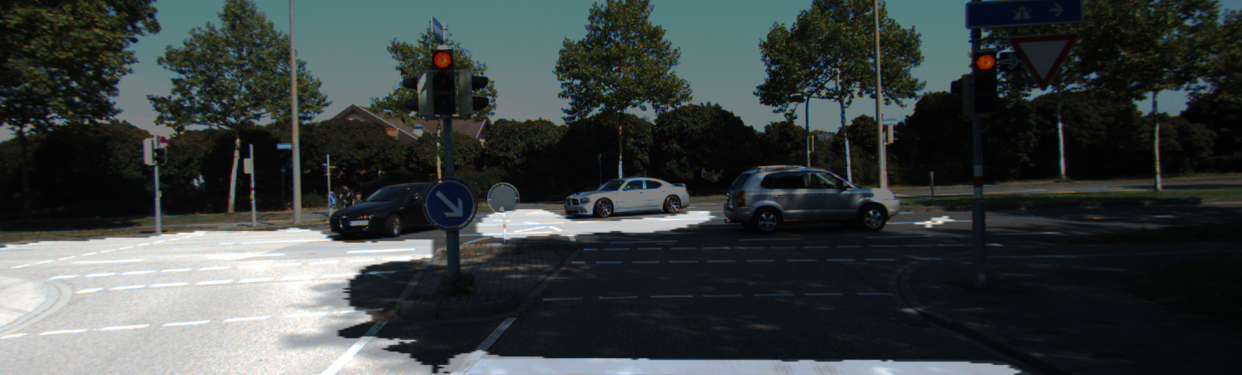

In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
    model_unet, 
    augmentation_test,
    image_path=PATH_BASE + '/data/training' + f'/image_2/00{str(i).zfill(4)}_10.png',
)

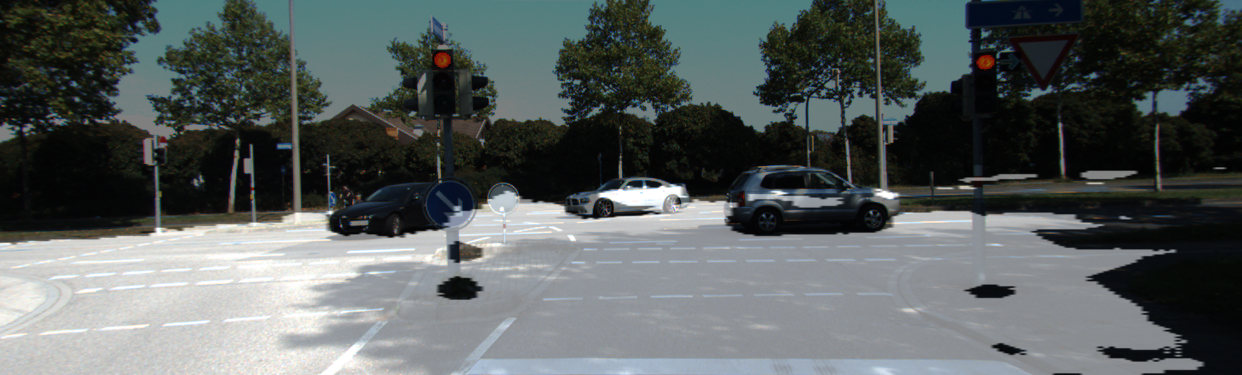

In [18]:
get_output(
    model_unet_adv, 
    augmentation_test,
    image_path=PATH_BASE + '/data/training' + f'/image_2/00{str(i).zfill(4)}_10.png',
)

In [15]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_1, prediction_1, target_1 = get_output_predict(
    model_unet, 
    augmentation_test,
    image_path=PATH_BASE + '/data/training' + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=PATH_BASE +'/data/training' + f'/result_{str(i).zfill(3)}_1.png',
    label_path=PATH_BASE +'/data/training' + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target_1, prediction_1)

IoU : 0.440355


0.4403554140972084

In [16]:
output_2, prediction_2, target_2 = get_output_predict(
    model_unet_adv, 
    augmentation_test,
    image_path=PATH_BASE + '/data/training' + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=PATH_BASE + '/data/training' + f'/result_{str(i).zfill(3)}_2.png',
    label_path=PATH_BASE + '/data/training' + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target_2, prediction_2)

IoU : 0.710580


0.7105803800719055

# Unet, Unet++ 비교
- IoU : 
    - Unet : 44.04% 
    - Unet++ : 71.06%

- 도로의 절반이상이 그늘, 확연한 성능차이가 보임
- Unet++이 더 좋은 성능


In [ ]:
import keras.backend as K

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        #axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        #classSelectors = K.argmax(true, axis=axis) 
        #if your loss is sparse, use only true as classSelectors
        classSelectors = true
   

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(K.cast(i, "uint8"), K.cast(classSelectors, "uint8")) for i in range(len(weightsList))]
       

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]
      

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier


        return loss
    return lossFunc


In [ ]:
from keras.losses import sparse_categorical_crossentropy

PATH_MODEL_UNET_ADV_LOSS = PATH_BASE+'/seg_model_unet_adv_loss.h5'

model_unet_adv_loss = build_model_adv_4()
model_unet_adv_loss.summary()


In [ ]:
class_weights = [1.1175, 6.0888, 0.4397, 0.9048]
model_unet_adv_loss.compile(optimizer = optimizers.Adam(1e-4), loss = weightedLoss(sparse_categorical_crossentropy, class_weights))
history_adv_loss  = model_unet_adv_loss.fit(
     train_generator_8_4,
     validation_data=test_generator_8_4,
     steps_per_epoch=len(train_generator_8_4),
     epochs=100,
)

model_unet_adv_loss.save(PATH_MODEL_UNET_ADV_LOSS)  #학습한 모델을 저장해 주세요.
